Previsão de crescimento da Indústria de Transformação

Preparação dos Dados

In [462]:
#Importanto Bibliotecas
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import glob
import re
from functools import reduce
from datetime import datetime
import locale
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
pd.set_option('display.max_columns', None)
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import arma_order_select_ic

In [463]:
locale.setlocale(locale.LC_ALL, 'pt_pt.UTF-8')

'pt_pt.UTF-8'

In [464]:
# Listando as bases
lista_de_bases = glob.glob("bases/*.csv")
lista_de_bases

['bases\\STP-20240227161120920-Indicadores_da_produção.csv',
 'bases\\STP-20240227161907632-PIB_MENSAL.csv',
 'bases\\STP-20240227162913656-IPCA.csv']

In [465]:
#Carregando bases
bases = []
for base_name in lista_de_bases:
    df_base = pd.read_csv(base_name, sep = ';', encoding='ANSI', decimal=',')
    bases.append(df_base)

In [466]:
#Juantando bases horizontalmente
df = reduce(lambda a, b : pd.merge(left = a, right = b, how = 'inner', on = ['Data']), bases)
df = df.loc[df['Data'] != 'Fonte']
df

,Data,21859 - Indicadores da produção (2022=100) - Geral - Índice,21861 - Indicadores da produção (2022=100) - Extrativa mineral - Índice,21862 - Indicadores da produção (2022=100) - Indústria de transformação - Índice,21863 - Indicadores da produção (2022=100) - Bens de capital - Índice,21864 - Indicadores da produção (2022=100) - Bens intermediários - Índice,21865 - Indicadores da produção (2022=100) - Bens de consumo - Índice,21866 - Indicadores da produção (2022=100) - Bens de consumo duráveis - Índice,21867 - Indicadores da produção (2022=100) - Semiduráveis e não duráveis - Índice,21868 - Indicadores da produção (2022=100) - Insumos da construção civil - Índice,4380 - PIB mensal - Valores correntes (R$ milhões) - R$ (milhões),11752 - Índice da taxa de câmbio real efetiva (IPCA) - Jun/1994=100 - Índice,11753 - Índice da taxa de câmbio real (IPCA) - Jun/1994=100 - Dólar americano - Índice,20360 - Índice da taxa de câmbio efetiva nominal - Jun/1994=100 - Índice
0,jan/02,"84,40","72,30","85,10","58,20","88,00","86,30","79,80","87,70",-,"112374,80","111,75","133,88","193,74"
1,fev/02,"81,20","68,30","82,10","56,80","85,20","82,10","77,00","83,10",-,"111477,10","111,03","136,27","188,11"
2,mar/02,"90,20","78,50","91,00","64,70","94,90","90,00","91,00","89,70",-,"118444,70","106,76","132,12","178,46"
3,abr/02,"92,80","77,10","93,80","68,90","96,00","94,60","101,80","92,80",-,"120385,90","105,39","130,33","173,20"
4,mai/02,"93,70","79,00","94,70","66,70","99,10","93,00","92,60","92,90",-,"123552,50","112,89","139,02","183,61"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257,jun/23,"102,00","109,10","100,80","91,90","103,10","102,00","94,50","103,10","100,30","895664,20","117,47","128,82","228,62"
258,jul/23,"105,80","113,10","104,60","86,30","106,60","108,00","95,10","110,10","103,60","912717,40","118,04","127,49","225,49"
259,ago/23,"111,30","110,00","111,50","97,70","109,00","118,30","119,20","118,10","107,70","923779,80","119,48","130,49","225,06"
260,set/23,"106,20","114,90","104,80","89,40","105,40","111,30","108,80","111,70","99,30","904464,20","118,73","131,41","223,25"


In [467]:
df['Data'] = df['Data'].apply(lambda x : datetime.strptime(x, '%b/%y'))

Análise Exploratória de Dados 

In [468]:
df.describe()

,Data
count,262
mean,2012-11-15 06:02:44.885496064
min,2002-01-01 00:00:00
25%,2007-06-08 12:00:00
50%,2012-11-16 00:00:00
75%,2018-04-23 12:00:00
max,2023-10-01 00:00:00


In [469]:
df.isnull().any()

Data                                                                                      False
21859 - Indicadores da produção (2022=100) - Geral - Índice                               False
21861 - Indicadores da produção (2022=100) - Extrativa mineral - Índice                   False
21862 - Indicadores da produção (2022=100) - Indústria de transformação - Índice          False
21863 - Indicadores da produção (2022=100) - Bens de capital - Índice                     False
21864 - Indicadores da produção (2022=100) - Bens intermediários - Índice                 False
21865 - Indicadores da produção (2022=100) - Bens de consumo - Índice                     False
21866 - Indicadores da produção (2022=100) - Bens de consumo duráveis - Índice            False
21867 - Indicadores da produção (2022=100) - Semiduráveis e não duráveis - Índice         False
21868 - Indicadores da produção (2022=100) - Insumos da construção civil - Índice         False
4380 - PIB mensal - Valores correntes (R

In [470]:
for col in df.columns[1:]:
    df[col] = df[col].apply(lambda x : x.strip().replace(',', '.')).replace('-',np.NaN).astype(float)

<AxesSubplot:xlabel='Data'>

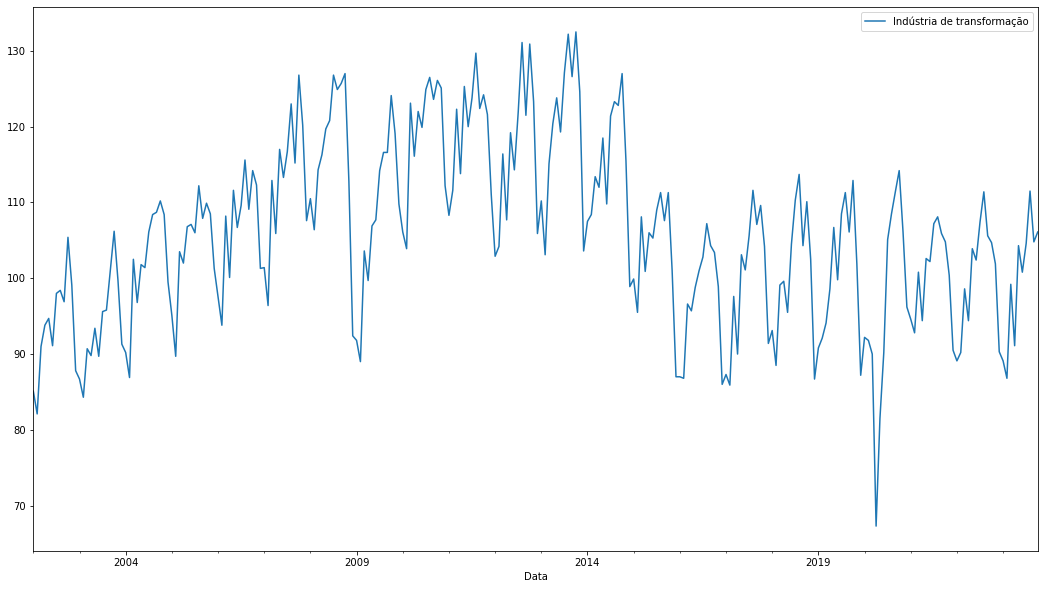

In [471]:
df_ind_transf = df.set_index('Data')[['21862 - Indicadores da produção (2022=100) - Indústria de transformação - Índice']].copy()
df_ind_transf.rename(columns={'21862 - Indicadores da produção (2022=100) - Indústria de transformação - Índice':'Indústria de transformação'}, inplace=True)
df_ind_transf.plot(figsize=(18,10))

In [472]:
#Média Móvel Simples
df['6-month-SMA'] = df['21862 - Indicadores da produção (2022=100) - Indústria de transformação - Índice'].rolling(window=6).mean()
df['12-month-SMA'] = df['21862 - Indicadores da produção (2022=100) - Indústria de transformação - Índice'].rolling(window=12).mean()
df

,Data,21859 - Indicadores da produção (2022=100) - Geral - Índice,21861 - Indicadores da produção (2022=100) - Extrativa mineral - Índice,21862 - Indicadores da produção (2022=100) - Indústria de transformação - Índice,21863 - Indicadores da produção (2022=100) - Bens de capital - Índice,21864 - Indicadores da produção (2022=100) - Bens intermediários - Índice,21865 - Indicadores da produção (2022=100) - Bens de consumo - Índice,21866 - Indicadores da produção (2022=100) - Bens de consumo duráveis - Índice,21867 - Indicadores da produção (2022=100) - Semiduráveis e não duráveis - Índice,21868 - Indicadores da produção (2022=100) - Insumos da construção civil - Índice,4380 - PIB mensal - Valores correntes (R$ milhões) - R$ (milhões),11752 - Índice da taxa de câmbio real efetiva (IPCA) - Jun/1994=100 - Índice,11753 - Índice da taxa de câmbio real (IPCA) - Jun/1994=100 - Dólar americano - Índice,20360 - Índice da taxa de câmbio efetiva nominal - Jun/1994=100 - Índice,6-month-SMA,12-month-SMA
0,2002-01-01,84.4,72.3,85.1,58.2,88.0,86.3,79.8,87.7,NaN,112374.8,111.75,133.88,193.74,NaN,NaN
1,2002-02-01,81.2,68.3,82.1,56.8,85.2,82.1,77.0,83.1,NaN,111477.1,111.03,136.27,188.11,NaN,NaN
2,2002-03-01,90.2,78.5,91.0,64.7,94.9,90.0,91.0,89.7,NaN,118444.7,106.76,132.12,178.46,NaN,NaN
3,2002-04-01,92.8,77.1,93.8,68.9,96.0,94.6,101.8,92.8,NaN,120385.9,105.39,130.33,173.20,NaN,NaN
4,2002-05-01,93.7,79.0,94.7,66.7,99.1,93.0,92.6,92.9,NaN,123552.5,112.89,139.02,183.61,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257,2023-06-01,102.0,109.1,100.8,91.9,103.1,102.0,94.5,103.1,100.3,895664.2,117.47,128.82,228.62,95.216667,99.383333
258,2023-07-01,105.8,113.1,104.6,86.3,106.6,108.0,95.1,110.1,103.6,912717.4,118.04,127.49,225.49,97.800000,99.150000
259,2023-08-01,111.3,110.0,111.5,97.7,109.0,118.3,119.2,118.1,107.7,923779.8,119.48,130.49,225.06,101.916667,99.158333
260,2023-09-01,106.2,114.9,104.8,89.4,105.4,111.3,108.8,111.7,99.3,904464.2,118.73,131.41,223.25,102.850000,99.091667


In [473]:
#DF Média Móvel Simples
dfSMA = df.set_index('Data')[['21862 - Indicadores da produção (2022=100) - Indústria de transformação - Índice', '6-month-SMA', '12-month-SMA']].copy()
dfSMA.rename(columns={'21862 - Indicadores da produção (2022=100) - Indústria de transformação - Índice':'Indústria de transformação'}, inplace=True)
dfSMA

,Indústria de transformação,6-month-SMA,12-month-SMA
Data,,,
2002-01-01,85.1,NaN,NaN
2002-02-01,82.1,NaN,NaN
2002-03-01,91.0,NaN,NaN
2002-04-01,93.8,NaN,NaN
2002-05-01,94.7,NaN,NaN
...,...,...,...
2023-06-01,100.8,95.216667,99.383333
2023-07-01,104.6,97.800000,99.150000
2023-08-01,111.5,101.916667,99.158333


<AxesSubplot:xlabel='Data'>

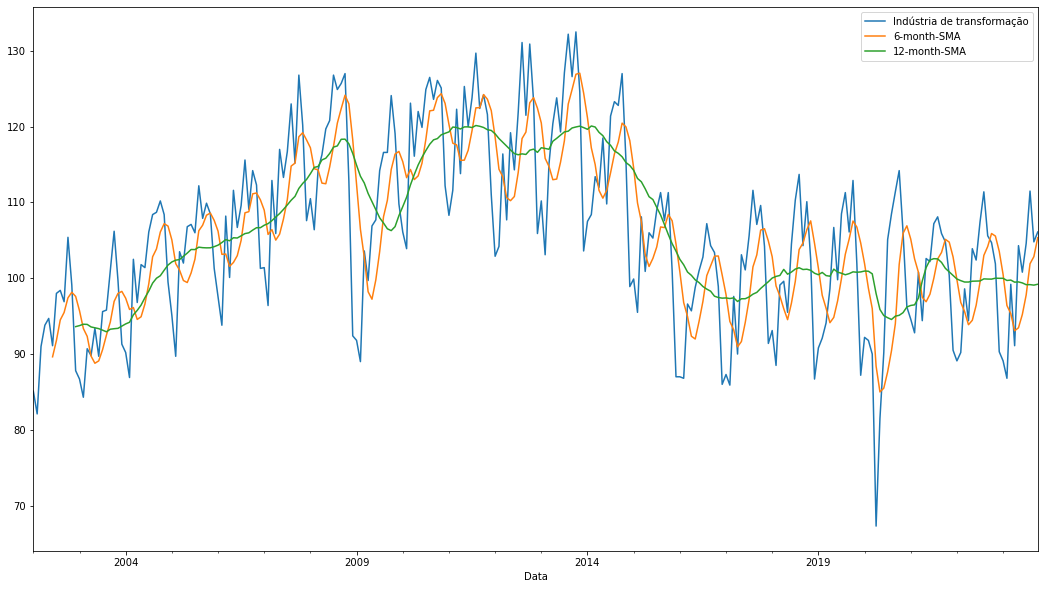

In [474]:
#Plotando Média Móvel Simpples
dfSMA.plot(figsize=(18,10))

In [475]:
df_ind_transf.head(2)

,Indústria de transformação
Data,
2002-01-01,85.1
2002-02-01,82.1


In [476]:
#Média Móvel Exponencialmente Ponderada
df['6-month-EWMA'] = df['21862 - Indicadores da produção (2022=100) - Indústria de transformação - Índice'].ewm(span=6,adjust=False).mean()
df['12-month-EWMA'] = df['21862 - Indicadores da produção (2022=100) - Indústria de transformação - Índice'].ewm(span=12,adjust=False).mean()
df

,Data,21859 - Indicadores da produção (2022=100) - Geral - Índice,21861 - Indicadores da produção (2022=100) - Extrativa mineral - Índice,21862 - Indicadores da produção (2022=100) - Indústria de transformação - Índice,21863 - Indicadores da produção (2022=100) - Bens de capital - Índice,21864 - Indicadores da produção (2022=100) - Bens intermediários - Índice,21865 - Indicadores da produção (2022=100) - Bens de consumo - Índice,21866 - Indicadores da produção (2022=100) - Bens de consumo duráveis - Índice,21867 - Indicadores da produção (2022=100) - Semiduráveis e não duráveis - Índice,21868 - Indicadores da produção (2022=100) - Insumos da construção civil - Índice,4380 - PIB mensal - Valores correntes (R$ milhões) - R$ (milhões),11752 - Índice da taxa de câmbio real efetiva (IPCA) - Jun/1994=100 - Índice,11753 - Índice da taxa de câmbio real (IPCA) - Jun/1994=100 - Dólar americano - Índice,20360 - Índice da taxa de câmbio efetiva nominal - Jun/1994=100 - Índice,6-month-SMA,12-month-SMA,6-month-EWMA,12-month-EWMA
0,2002-01-01,84.4,72.3,85.1,58.2,88.0,86.3,79.8,87.7,NaN,112374.8,111.75,133.88,193.74,NaN,NaN,85.100000,85.100000
1,2002-02-01,81.2,68.3,82.1,56.8,85.2,82.1,77.0,83.1,NaN,111477.1,111.03,136.27,188.11,NaN,NaN,84.242857,84.638462
2,2002-03-01,90.2,78.5,91.0,64.7,94.9,90.0,91.0,89.7,NaN,118444.7,106.76,132.12,178.46,NaN,NaN,86.173469,85.617160
3,2002-04-01,92.8,77.1,93.8,68.9,96.0,94.6,101.8,92.8,NaN,120385.9,105.39,130.33,173.20,NaN,NaN,88.352478,86.876058
4,2002-05-01,93.7,79.0,94.7,66.7,99.1,93.0,92.6,92.9,NaN,123552.5,112.89,139.02,183.61,NaN,NaN,90.166056,88.079742
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257,2023-06-01,102.0,109.1,100.8,91.9,103.1,102.0,94.5,103.1,100.3,895664.2,117.47,128.82,228.62,95.216667,99.383333,98.166627,98.138794
258,2023-07-01,105.8,113.1,104.6,86.3,106.6,108.0,95.1,110.1,103.6,912717.4,118.04,127.49,225.49,97.800000,99.150000,100.004733,99.132826
259,2023-08-01,111.3,110.0,111.5,97.7,109.0,118.3,119.2,118.1,107.7,923779.8,119.48,130.49,225.06,101.916667,99.158333,103.289095,101.035468
260,2023-09-01,106.2,114.9,104.8,89.4,105.4,111.3,108.8,111.7,99.3,904464.2,118.73,131.41,223.25,102.850000,99.091667,103.720782,101.614627


In [477]:
#DF Média Móvel Exponencialmente Ponderada
dfEWMA = df.set_index('Data')[['21862 - Indicadores da produção (2022=100) - Indústria de transformação - Índice', '6-month-SMA', '12-month-SMA']].copy()
dfEWMA.rename(columns={'21862 - Indicadores da produção (2022=100) - Indústria de transformação - Índice':'Indústria de transformação'}, inplace=True)
dfEWMA

,Indústria de transformação,6-month-SMA,12-month-SMA
Data,,,
2002-01-01,85.1,NaN,NaN
2002-02-01,82.1,NaN,NaN
2002-03-01,91.0,NaN,NaN
2002-04-01,93.8,NaN,NaN
2002-05-01,94.7,NaN,NaN
...,...,...,...
2023-06-01,100.8,95.216667,99.383333
2023-07-01,104.6,97.800000,99.150000
2023-08-01,111.5,101.916667,99.158333


<AxesSubplot:xlabel='Data'>

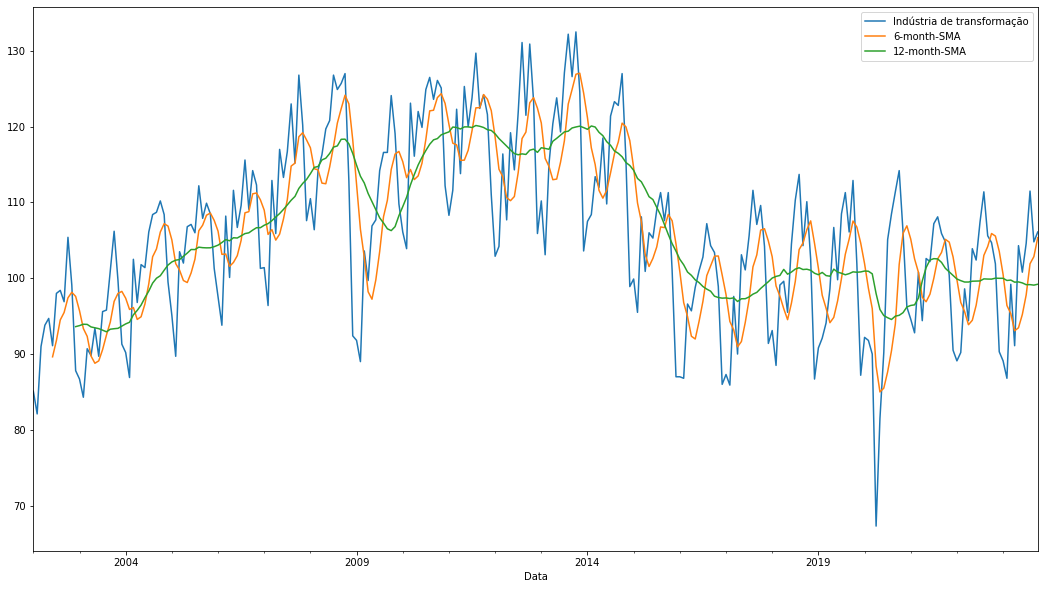

In [478]:
#Plotando Média Móvel Exponencialmente Ponderada
dfEWMA.plot(figsize=(18,10))

In [479]:
#Identificando Outliers
def detect_outliers_iqr(data):
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = (data < lower_bound) | (data > upper_bound)
    return outliers


In [480]:
#Identificando Outliers
industria_outliers = df_ind_transf['Indústria de transformação']  
outliers_iqr = detect_outliers_iqr(industria_outliers)
print("Outliers detectados pelo método IQR:")
print(industria_outliers[outliers_iqr])

Outliers detectados pelo método IQR:
Data
2020-04-01    67.3
Name: Indústria de transformação, dtype: float64


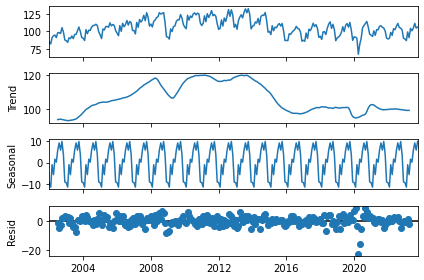

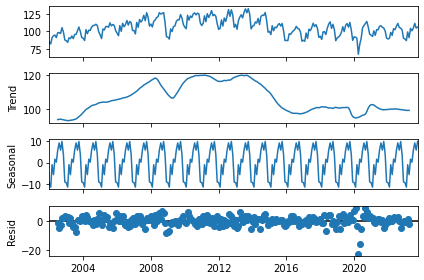

In [481]:
#Decomposição Sazonal - Add
from statsmodels.tsa.seasonal import seasonal_decompose

seasonal_decompose(df_ind_transf,model='add').plot()



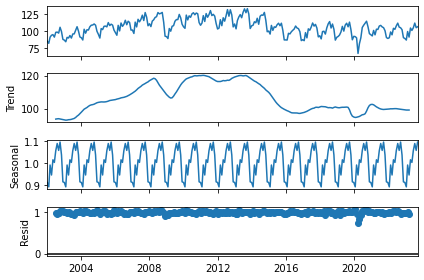

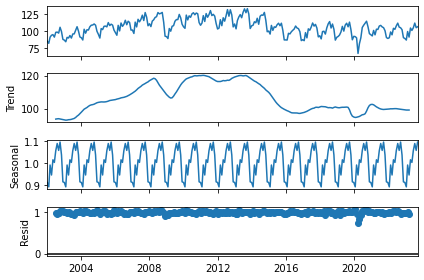

In [482]:
#Decomposição Sazonal - Mul
seasonal_decompose(df_ind_transf,model='mul').plot()

Modelo 1: ETS - Suavização Exponencial Tripla

In [483]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [484]:
len(df_ind_transf)

262

In [485]:
dados_treinados = df_ind_transf.iloc[:210] # Primeiras 80% das linhas (262 * 0.8 = 209,6)
dados_testados= df_ind_transf.iloc[210:] # Últimos 20% das linhas (262 - 210 = 52)


In [486]:
# Criando o modelo de Suavização Exponencial Tripla
fitted_model = ExponentialSmoothing(
    dados_treinados['Indústria de transformação'],
    trend='mul',
    seasonal='mul',
    seasonal_periods=12
).fit()

# Fazendo previsões
etsprevi = fitted_model.forecast(52).rename('ETS Previsão')

In [487]:
etsprevi

2019-07-01    105.989640
2019-08-01    109.427157
2019-09-01    105.990579
2019-10-01    110.265992
2019-11-01    104.591380
2019-12-01     92.271516
2020-01-01     91.880745
2020-02-01     89.687099
2020-03-01    100.352241
2020-04-01     97.487299
2020-05-01    103.396484
2020-06-01    101.313618
2020-07-01    106.203489
2020-08-01    109.647942
2020-09-01    106.204431
2020-10-01    110.488469
2020-11-01    104.802408
2020-12-01     92.457686
2021-01-01     92.066127
2021-02-01     89.868055
2021-03-01    100.554716
2021-04-01     97.683994
2021-05-01    103.605101
2021-06-01    101.518033
2021-07-01    106.417769
2021-08-01    109.869172
2021-09-01    106.418713
2021-10-01    110.711396
2021-11-01    105.013862
2021-12-01     92.644233
2022-01-01     92.251884
2022-02-01     90.049377
2022-03-01    100.757600
2022-04-01     97.881085
2022-05-01    103.814139
2022-06-01    101.722860
2022-07-01    106.632482
2022-08-01    110.090849
2022-09-01    106.633428
2022-10-01    110.934772


In [488]:
# Ajustando o índice para corresponder aos dados testados
etsprevi.index = dados_testados.index

In [489]:
# Calcular as métricas de avaliação
mae = mean_absolute_error(dados_testados['Indústria de transformação'], etsprevi)
mse = mean_squared_error(dados_testados['Indústria de transformação'], etsprevi)
r2 = r2_score(dados_testados['Indústria de transformação'], etsprevi)
# Imprimir as métricas
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("R-squared (R²):", r2)

Mean Absolute Error (MAE): 3.5740840371766796
Mean Squared Error (MSE): 38.96326617288204
R-squared (R²): 0.5379293373068763


<AxesSubplot:xlabel='Data'>

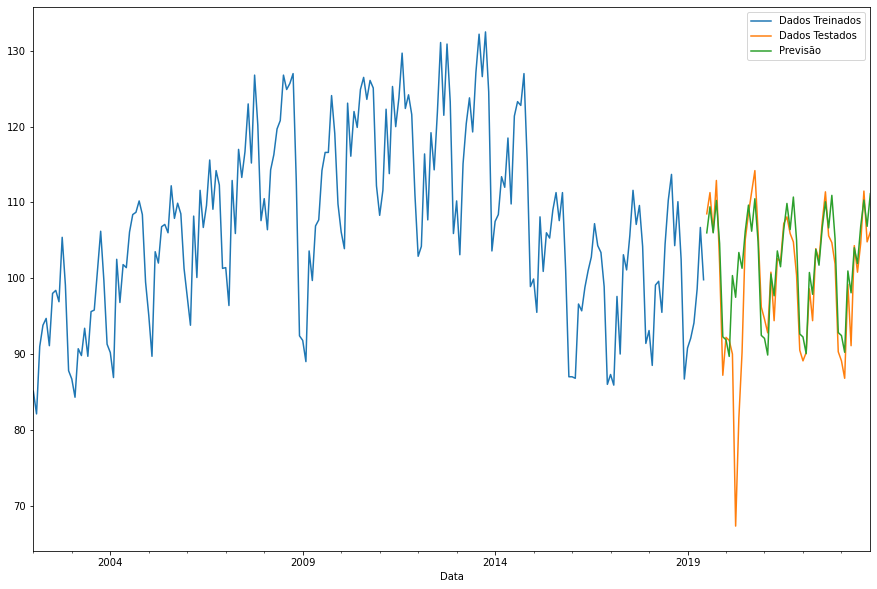

In [490]:
# Plotando os dados
dados_treinados['Indústria de transformação'].plot(legend=True, label='Dados Treinados')
dados_testados['Indústria de transformação'].plot(legend=True, label='Dados Testados', figsize=(15, 10))
etsprevi.plot(legend=True, label='Previsão')

Modelo 2: A Regressão Linear Múltipla

In [491]:
# Criar um novo DataFrame (df2) sem as colunas especificadas
df2 = df.drop(['6-month-SMA', '12-month-SMA', '6-month-EWMA', '12-month-EWMA','21868 - Indicadores da produção (2022=100) - Insumos da construção civil - Índice'], axis=1).copy()


In [492]:
# Definir as variáveis independentes (X) e a variável dependente (y)
X = df2[['21859 - Indicadores da produção (2022=100) - Geral - Índice',
         '21861 - Indicadores da produção (2022=100) - Extrativa mineral - Índice',
         '21863 - Indicadores da produção (2022=100) - Bens de capital - Índice',
         '21864 - Indicadores da produção (2022=100) - Bens intermediários - Índice',
         '21865 - Indicadores da produção (2022=100) - Bens de consumo - Índice',
         '21866 - Indicadores da produção (2022=100) - Bens de consumo duráveis - Índice',
         '21867 - Indicadores da produção (2022=100) - Semiduráveis e não duráveis - Índice',
         '11752 - Índice da taxa de câmbio real efetiva (IPCA) - Jun/1994=100 - Índice',
         '11753 - Índice da taxa de câmbio real (IPCA) - Jun/1994=100 - Dólar americano - Índice',
         '20360 - Índice da taxa de câmbio efetiva nominal - Jun/1994=100 - Índice']]

y = df2['21862 - Indicadores da produção (2022=100) - Indústria de transformação - Índice']



In [493]:
# Definir as variáveis independentes (X) excluindo a variável alvo
X_train = df2.iloc[:210].drop(['Data', '21862 - Indicadores da produção (2022=100) - Indústria de transformação - Índice'], axis=1)
X_test = df2.iloc[210:262].drop(['Data', '21862 - Indicadores da produção (2022=100) - Indústria de transformação - Índice'], axis=1)

# Definir a variável dependente (y) para os conjuntos de treinamento e teste
y_train = df2['21862 - Indicadores da produção (2022=100) - Indústria de transformação - Índice'][:210]
y_test = df2['21862 - Indicadores da produção (2022=100) - Indústria de transformação - Índice'][210:262]


In [494]:
# Criar o modelo de regressão linear
model = LinearRegression()

In [495]:
# Treinar o modelo com os dados de treinamento
model.fit(X_train, y_train)

LinearRegression()

In [496]:

# Imprimir as métricas de desempenho
print("Erro médio quadrático:", mse)
print("Coeficiente de determinação (R²):", r2)

Erro médio quadrático: 38.96326617288204
Coeficiente de determinação (R²): 0.5379293373068763


In [497]:
# Calcular métricas de desempenho
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

In [498]:
# Fazer previsões usando os dados de teste
y_pred = model.predict(X_test)

In [499]:
y_pred

array([108.5096467 , 111.2962831 , 106.04910103, 112.92283299,
       102.0255703 ,  87.36486713,  92.0856391 ,  91.62326072,
        89.84426313,  67.05237791,  81.09218825,  89.92802876,
       104.85686828, 108.21029951, 111.09676528, 113.87010082,
       105.90289051,  96.27157619,  94.61185817,  92.67637931,
       100.57754525,  94.28677367, 102.66028157, 102.19618093,
       107.28593125, 108.20933194, 106.0635779 , 104.88863378,
       100.52405544,  90.7512772 ,  89.15669219,  90.10449835,
        98.62917982,  94.54374557, 103.74776708, 102.23637026,
       107.25181559, 111.28817831, 105.58307429, 105.15768028,
       101.78624287,  90.89126483,  89.14916106,  86.93831522,
        99.4240236 ,  91.15523283, 104.22176112, 101.12774495,
       104.63807827, 111.1280395 , 104.9649607 , 106.18536209])

In [500]:
# Criar uma série de datas correspondentes aos meses para os dados de teste
dates_test = df2.iloc[210:262]['Data']

In [501]:
# Criar um DataFrame com as datas e as previsões
predictions_df = pd.DataFrame({'Data': dates_test, 'Previsões': y_pred})

In [502]:
predictions_df.head()

,Data,Previsões
210,2019-07-01,108.509647
211,2019-08-01,111.296283
212,2019-09-01,106.049101
213,2019-10-01,112.922833
214,2019-11-01,102.025570


In [503]:
# Extrair o histórico correspondente aos dados de teste
historical_data = df2.iloc[210:262]

In [504]:
# Configurar o índice do DataFrame como as datas
predictions_df.set_index('Data', inplace=True)

In [505]:
# Converter a coluna de datas para uma lista de datas
datas = historical_data['Data'].tolist()

In [506]:
# Criar uma lista de datas para as previsões
dates = pd.date_range(start='2023-01-01', periods=len(predictions_df), freq='MS')

# Adicionar as datas ao DataFrame predictions_df
predictions_df['Data'] = dates

# Definir a coluna 'Data' como índice
predictions_df.set_index('Data', inplace=True)


In [507]:
# Criar DataFrame apenas com as colunas 'Data' e '21862 - Indicadores da produção (2022=100) - Indústria de transformação - Índice'
df_transformacao = df2[['Data', '21862 - Indicadores da produção (2022=100) - Indústria de transformação - Índice']].copy()


# Definir a coluna 'Data' como índice do DataFrame df_transformacao
df_transformacao.set_index('Data', inplace=True)
# Exibir as primeiras linhas do DataFrame para verificação
df_transformacao.head()



,21862 - Indicadores da produção (2022=100) - Indústria de transformação - Índice
Data,
2002-01-01,85.1
2002-02-01,82.1
2002-03-01,91.0
2002-04-01,93.8
2002-05-01,94.7


In [508]:
# Remover linhas com valores NaN
df_ind_clean = df_ind.dropna(subset=['Previsões'])

In [509]:
# Converter o índice de predictions_df para o tipo datetime
predictions_df.index = pd.to_datetime(predictions_df.index)

# Selecionar as previsões até junho de 2024
predictions_until_june_2024 = predictions_df.loc[predictions_df.index <= '2024-06-01']

In [510]:
predictions_until_june_2024

,Previsões
Data,
2023-01-01,108.509647
2023-02-01,111.296283
2023-03-01,106.049101
2023-04-01,112.922833
2023-05-01,102.025570
2023-06-01,87.364867
2023-07-01,92.085639
2023-08-01,91.623261
2023-09-01,89.844263


In [511]:
df_transformacao

,21862 - Indicadores da produção (2022=100) - Indústria de transformação - Índice
Data,
2002-01-01,85.1
2002-02-01,82.1
2002-03-01,91.0
2002-04-01,93.8
2002-05-01,94.7
...,...
2023-06-01,100.8
2023-07-01,104.6
2023-08-01,111.5


In [512]:
#Concatenar
df_combined = pd.merge(df_transformacao.reset_index(), predictions_until_june_2024.reset_index(), on = 'Data', how = 'left').reset_index(drop = True).set_index('Data')
df_combined

,21862 - Indicadores da produção (2022=100) - Indústria de transformação - Índice,Previsões
Data,,
2002-01-01,85.1,NaN
2002-02-01,82.1,NaN
2002-03-01,91.0,NaN
2002-04-01,93.8,NaN
2002-05-01,94.7,NaN
...,...,...
2023-06-01,100.8,87.364867
2023-07-01,104.6,92.085639
2023-08-01,111.5,91.623261


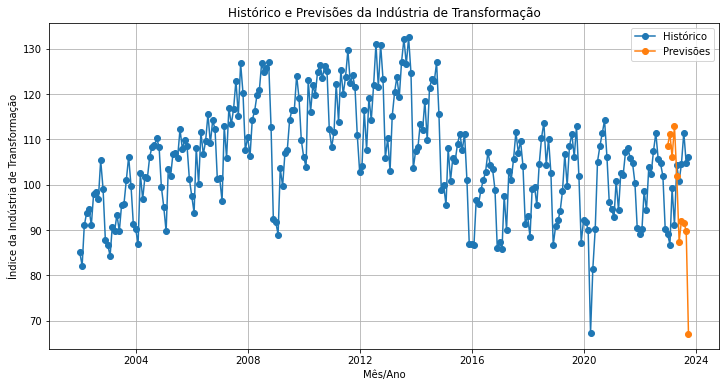

In [513]:
# Plotar o histórico e as previsões até junho de 2024
plt.figure(figsize=(12, 6))
plt.plot(df_combined['21862 - Indicadores da produção (2022=100) - Indústria de transformação - Índice'], marker='o', label='Histórico')
plt.plot(df_combined['Previsões'], marker='o', label='Previsões')
plt.xlabel('Mês/Ano')
plt.ylabel('Índice da Indústria de Transformação')
plt.title('Histórico e Previsões da Indústria de Transformação')
plt.legend()
plt.grid(True)
plt.show()


Modelo 3: Modelo auto-regressivo

In [514]:
import warnings
warnings.filterwarnings("ignore")

In [515]:
data = df_ind_transf['Indústria de transformação']

In [516]:
max_lags = 10 
res = arma_order_select_ic(data, max_ar=max_lags, ic='aic', trend='c')
p = res.aic_min_order[0] 

In [517]:
# Dividindo os dados em conjuntos de treinamento e teste
train_data = data[:210]
test_data = data[210:]

In [518]:
model = AutoReg(train_data, lags=p)
model_fit = model.fit()

In [519]:
predictions = model_fit.predict(start=len(train_data), end=len(train_data)+len(test_data)-1)

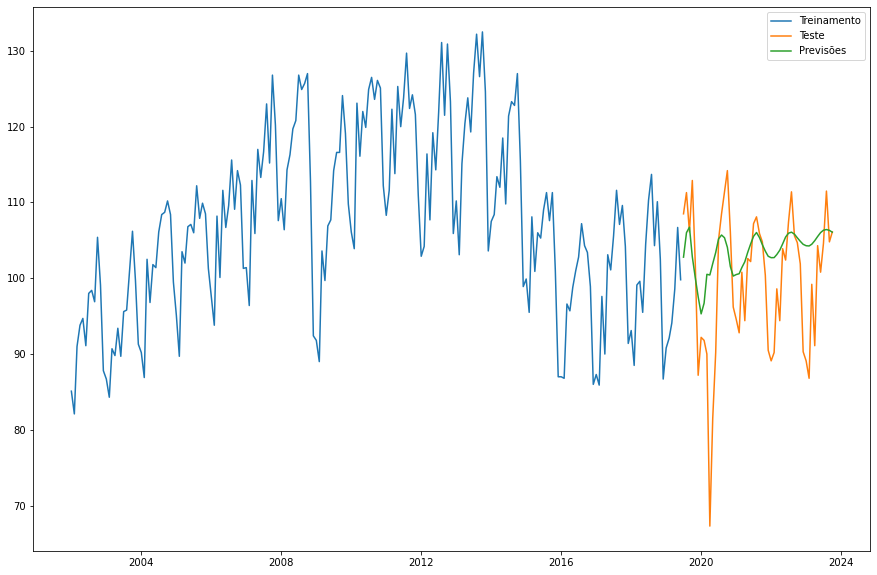

In [520]:
plt.figure(figsize=(15, 10))
plt.plot(train_data, label='Treinamento')
plt.plot(test_data, label='Teste')
plt.plot(predictions, label='Previsões')
plt.legend()
plt.show()

In [521]:
predictions

2019-07-01    102.781750
2019-08-01    106.010231
2019-09-01    106.737900
2019-10-01    102.819761
2019-11-01    100.058614
2019-12-01     97.563178
2020-01-01     95.299405
2020-02-01     96.712658
2020-03-01    100.516659
2020-04-01    100.430205
2020-05-01    101.928041
2020-06-01    103.393242
2020-07-01    105.194969
2020-08-01    105.702496
2020-09-01    105.344341
2020-10-01    104.078754
2020-11-01    101.537684
2020-12-01    100.286487
2021-01-01    100.484985
2021-02-01    100.597322
2021-03-01    101.410420
2021-04-01    102.177887
2021-05-01    103.405904
2021-06-01    104.530276
2021-07-01    105.525129
2021-08-01    106.031047
2021-09-01    105.364922
2021-10-01    104.432394
2021-11-01    103.571991
2021-12-01    102.900164
2022-01-01    102.711676
2022-02-01    102.723453
2022-03-01    103.125990
2022-04-01    103.702413
2022-05-01    104.536336
2022-06-01    105.441484
2022-07-01    105.940956
2022-08-01    106.078584
2022-09-01    105.813152
2022-10-01    105.336317


In [522]:
# MAE
mae = mean_absolute_error(test_data, predictions)

# MSE
mse = mean_squared_error(test_data, predictions)

# R²
r2 = r2_score(test_data, predictions)

print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("R-squared (R²):", r2)

Mean Absolute Error (MAE): 6.295203930530026
Mean Squared Error (MSE): 79.61245096663582
R-squared (R²): 0.05586513683033467
